In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl
from tabulate import tabulate
from helpers.util_functions import normalise_value

from moral.ppo import PPO, TrajectoryDataset, update_policy
from envs.gym_wrapper import *
import random

from quality_metrics.validity_measures import validity_all as validity
from quality_metrics.validity_measures import validity_single, validity_single_partial
from quality_metrics.distance_measures import distance_all as distance
from quality_metrics.distance_measures import distance_single
from quality_metrics.diversity_measures import diversity_all as diversity
from quality_metrics.diversity_measures import diversity_single, distance_subtrajectories
from quality_metrics.critical_state_measures import critical_state_all as critical_state
from quality_metrics.critical_state_measures import critical_state_single
from quality_metrics.realisticness_measures import realisticness_all as realisticness
from quality_metrics.realisticness_measures import realisticness_single_partial
from quality_metrics.sparsity_measure import sparsity_all as sparsity
from quality_metrics.sparsity_measure import sparsitiy_single_partial

c:\Users\janwe\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


# Analysing quality criterias

I will visualize the distribution of quality criteria

In [2]:
class config:
    env_id= 'randomized_v2'
    env_steps= 8e6
    batchsize_ppo= 12
    n_queries= 50
    preference_noise= 0
    n_workers= 1
    lr_ppo= 3e-4
    entropy_reg= 0.25
    gamma= 0.999
    epsilon= 0.1
    ppo_epochs= 5
    max_steps = 75
    base_path = '.\datasets\\100mstep\\'
    measure_statistics = True
    num_runs = 100
    criteria = ['validity', 'diversity', 'proximity', 'critical_state', 'realisticness', 'sparsity']
    # criteria = ['baseline']
    # criteria = ['validity']
    cf_method = 'step' # 'mcts' or 'step'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
# load the trajectories
with open('..\..\datasets\\100mcts\\100\cf_trajectories.pkl', 'rb') as f:
    cf_mcts = pkl.load(f)
with open('..\..\datasets\\100mcts\\100\org_trajectories.pkl', 'rb') as f:
    org_mcts = pkl.load(f)
with open('..\..\datasets\\100mcts\\100\statistics\start_points.pkl', 'rb') as f:
    starts_mcts = pkl.load(f)

with open('..\..\datasets\\100step\\100\cf_trajectories.pkl', 'rb') as f:
    cf_step = pkl.load(f)
with open('..\..\datasets\\100step\\100\org_trajectories.pkl', 'rb') as f:
    org_step = pkl.load(f)
with open('..\..\datasets\\100step\\100\statistics\start_points.pkl', 'rb') as f:
    starts_step = pkl.load(f)

with open('..\..\datasets\\100random\\100\cf_trajectories.pkl', 'rb') as f:
    cf_random = pkl.load(f)
with open('..\..\datasets\\100random\\100\org_trajectories.pkl', 'rb') as f:
    org_random = pkl.load(f)
with open('..\..\datasets\\100random\\100\statistics\start_points.pkl', 'rb') as f:
    starts_random = pkl.load(f)

In [10]:
# Load normalisation

with open('..\..\interpretability\\normalisation_values_new.pkl', 'rb') as f:
    normalisation = pkl.load(f)

weight = {'validity': 1, 'proximity': 1, 'critical_state': 0.5, 'diversity': 0.5, 'realisticness': 0.2, 'sparsity': 0.5}

random.seed(4)
seed_env = random.randint(0, 100000)
torch.manual_seed(seed_env)
np.random.seed(seed_env)

# Create Environment
vec_env = VecEnv(config.env_id, config.n_workers, seed=seed_env)
states = vec_env.reset()
states_tensor = torch.tensor(states).float().to(device)

# Fetch Shapes
n_actions = vec_env.action_space.n
obs_shape = vec_env.observation_space.shape
state_shape = obs_shape[:-1]
in_channels = obs_shape[-1]

ppo = PPO(state_shape=state_shape, in_channels=in_channels, n_actions=n_actions).to(device)
ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10].pt', map_location=torch.device('cpu')))
# ppo.load_state_dict(torch.load('..\..\saved_models/ppo_airl_v2_[1,10]_new.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
mcts_val, mcts_prox, mcts_div, mcts_crit, mcts_spar, mcts_real, mcts_qc = [], [], [], [], [], [], []
prev_org_trajs, prev_cf_trajs, prev_starts = [], [], []

for i in range(100):
    val = validity_single_partial(org_mcts[i][0], cf_mcts[i][0])
    val = normalise_value(val, normalisation, 'validity') * weight['validity']
    mcts_val.append(val)
    prox = distance_subtrajectories(org_mcts[i][0], cf_mcts[i][0])
    prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
    mcts_prox.append(prox)
    div = diversity_single(org_mcts[i][0], cf_mcts[i][0], starts_mcts[i], prev_org_trajs, prev_cf_trajs, prev_starts)
    div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
    mcts_div.append(div)
    crit = critical_state_single(ppo, org_mcts[i][0]['states'][0])
    crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
    mcts_crit.append(crit)
    spar = sparsitiy_single_partial(org_mcts[i][0], cf_mcts[i][0])
    spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
    mcts_spar.append(spar)
    real = realisticness_single_partial(org_mcts[i][0], cf_mcts[i][0])
    real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
    mcts_real.append(real)
    qc = val + prox + div + crit + spar + real
    mcts_qc.append(qc)

    prev_org_trajs.append(org_mcts[i][0])
    prev_cf_trajs.append(cf_mcts[i][0])
    prev_starts.append(starts_mcts[i])

step_val, step_prox, step_div, step_crit, step_spar, step_real, step_qc = [], [], [], [], [], [], []
prev_org_trajs, prev_cf_trajs, prev_starts = [], [], []

for i in range(100):
    val = validity_single_partial(org_step[i][0], cf_step[i][0])
    val = normalise_value(val, normalisation, 'validity') * weight['validity']
    step_val.append(val)
    prox = distance_subtrajectories(org_step[i][0], cf_step[i][0])
    prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
    step_prox.append(prox)
    div = diversity_single(org_step[i][0], cf_step[i][0], starts_step[i], prev_org_trajs, prev_cf_trajs, prev_starts)
    div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
    step_div.append(div)
    crit = critical_state_single(ppo, org_step[i][0]['states'][0])
    crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
    step_crit.append(crit)
    spar = sparsitiy_single_partial(org_step[i][0], cf_step[i][0])
    spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
    step_spar.append(spar)
    
    real = realisticness_single_partial(org_step[i][0], cf_step[i][0])
    real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
    if real > 10:
        real =2
    step_real.append(real)
    qc = val + prox + div + crit + spar + real
    step_qc.append(qc)

    prev_org_trajs.append(org_step[i][0])
    prev_cf_trajs.append(cf_step[i][0])
    prev_starts.append(starts_step[i])

random_val, random_prox, random_div, random_crit, random_spar, random_real, random_qc = [], [], [], [], [], [], []
prev_org_trajs, prev_cf_trajs, prev_starts = [], [], []

for i in range(100):
    val = validity_single_partial(org_random[i][0], cf_random[i][0])
    val = normalise_value(val, normalisation, 'validity') * weight['validity']
    random_val.append(val)
    prox = distance_subtrajectories(org_random[i][0], cf_random[i][0])
    prox = normalise_value(prox, normalisation, 'proximity') * weight['proximity']
    random_prox.append(prox)
    div = diversity_single(org_random[i][0], cf_random[i][0], starts_random[i], prev_org_trajs, prev_cf_trajs, prev_starts)
    div = normalise_value(div, normalisation, 'diversity') * weight['diversity']
    random_div.append(div)
    crit = critical_state_single(ppo, org_random[i][0]['states'][0])
    crit = normalise_value(crit, normalisation, 'critical_state') * weight['critical_state']
    random_crit.append(crit)
    spar = sparsitiy_single_partial(org_random[i][0], cf_random[i][0])
    spar = normalise_value(spar, normalisation, 'sparsity') * weight['sparsity']
    random_spar.append(spar)
    real = realisticness_single_partial(org_random[i][0], cf_random[i][0])
    real = normalise_value(real, normalisation, 'realisticness') * weight['realisticness']
    random_real.append(real)
    qc = val + prox + div + crit + spar + real
    random_qc.append(qc)

    prev_org_trajs.append(org_random[i][0])
    prev_cf_trajs.append(cf_random[i][0])
    prev_starts.append(starts_random[i])


In [15]:
# print the average and standard deviation of the statistics
table = [
    ['statistics'] + ['mcts mean'] + ['mcts std'] + ['step mean'] + ['step std'] + ['random mean'] + ['random std'],
    ['validity'] + [round(np.mean(mcts_val), 2), round(np.std(mcts_val), 2)] + [round(np.mean(step_val), 2), round(np.std(step_val), 2)] + [round(np.mean(random_val), 2), round(np.std(random_val), 2)],
    ['proximity'] + [round(np.mean(mcts_prox), 2), round(np.std(mcts_prox), 2)] + [round(np.mean(step_prox), 2), round(np.std(step_prox), 2)] + [round(np.mean(random_prox), 2), round(np.std(random_prox), 2)],
    ['diversity'] + [round(np.mean(mcts_div), 2), round(np.std(mcts_div), 2)] + [round(np.mean(step_div), 2), round(np.std(step_div), 2)] + [round(np.mean(random_div), 2), round(np.std(random_div), 2)],
    ['critical'] + [round(np.mean(mcts_crit), 2), round(np.std(mcts_crit), 2)] + [round(np.mean(step_crit), 2), round(np.std(step_crit), 2)] + [round(np.mean(random_crit), 2), round(np.std(random_crit), 2)],
    ['realistic'] + [round(np.mean(mcts_real), 2), round(np.std(mcts_real), 2)] + [round(np.mean(step_real), 2), round(np.std(step_real), 2)] + [round(np.mean(random_real), 2), round(np.std(random_real), 2)],
    ['sparsity'] + [round(np.mean(mcts_spar), 2), round(np.std(mcts_spar), 2)] + [round(np.mean(step_spar), 2), round(np.std(step_spar), 2)] + [round(np.mean(random_spar), 2), round(np.std(random_spar), 2)],
    ['qc'] + [round(np.mean(mcts_qc), 2), round(np.std(mcts_qc), 2)] + [round(np.mean(step_qc), 2), round(np.std(step_qc), 2)] + [round(np.mean(random_qc), 2), round(np.std(random_qc), 2)]
]

# make the table, but only with the means
table = [
    ['statistics'] + ['mcts mean'] + ['step mean'] + ['random mean'],
    ['validity'] + [round(np.mean(mcts_val), 2)] + [round(np.mean(step_val), 2)] + [round(np.mean(random_val), 2)],
    ['proximity'] + [round(np.mean(mcts_prox), 2)] + [round(np.mean(step_prox), 2)] + [round(np.mean(random_prox), 2)],
    
    ['critical'] + [round(np.mean(mcts_crit), 2)] + [round(np.mean(step_crit), 2)] + [round(np.mean(random_crit), 2)],
    ['realistic'] + [round(np.mean(mcts_real), 2)] + [round(np.mean(step_real), 2)] + [round(np.mean(random_real), 2)],
    ['sparsity'] + [round(np.mean(mcts_spar), 2)] + [round(np.mean(step_spar), 2)] + [round(np.mean(random_spar), 2)],
    ['diversity'] + [round(np.mean(mcts_div), 2)] + [round(np.mean(step_div), 2)] + [round(np.mean(random_div), 2)],
    ['qc'] + [round(np.mean(mcts_qc), 2)] + [round(np.mean(step_qc), 2)] + [round(np.mean(random_qc), 2)]
    
]

print(tabulate(table, headers='firstrow', tablefmt='latex'))
# index of the highest qc_step
print(step_real.index(max(step_real)))
print(max(step_real), min(step_real))
print(max(mcts_real), min(mcts_real))
print(max(random_real), min(random_real))


\begin{tabular}{lrrr}
\hline
 statistics   &   mcts mean &   step mean &   random mean \\
\hline
 validity     &        0.7  &        0.46 &          0.2  \\
 proximity    &        0.21 &        0.09 &          0.11 \\
 critical     &        0.49 &        0.47 &          0.15 \\
 realistic    &        0.05 &        0.2  &          0.04 \\
 sparsity     &        0.49 &        0.49 &          0.45 \\
 diversity    &        0.03 &        0.03 &          0.06 \\
 qc           &        1.97 &        1.74 &          1.01 \\
\hline
\end{tabular}
88
8.781542726142229 0.017677963490914914
0.5336067279783719 0.026190222689240778
0.45642701134179237 -0.03482941333284409


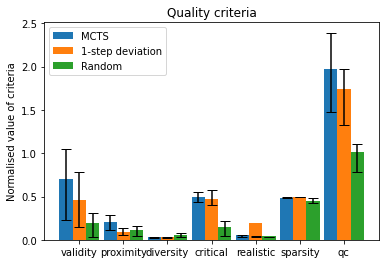

In [14]:
# Plot the quality criteria

criteria = ['validity', 'proximity', 'diversity', 'critical', 'realistic', 'sparsity', 'qc']

mcts_means = [np.mean(mcts_val), np.mean(mcts_prox), np.mean(mcts_div), np.mean(mcts_crit), np.mean(mcts_real), np.mean(mcts_spar), np.mean(mcts_qc)]
mcts_upper = [np.percentile(mcts_val, 75), np.percentile(mcts_prox, 75), np.percentile(mcts_div, 75), np.percentile(mcts_crit, 75), np.percentile(mcts_real, 75), np.percentile(mcts_spar, 75), np.percentile(mcts_qc, 75)]
mcts_lower = [np.percentile(mcts_val, 25), np.percentile(mcts_prox, 25), np.percentile(mcts_div, 25), np.percentile(mcts_crit, 25), np.percentile(mcts_real, 25), np.percentile(mcts_spar, 25), np.percentile(mcts_qc, 25)]

step_means = [np.mean(step_val), np.mean(step_prox), np.mean(step_div), np.mean(step_crit), np.mean(step_real), np.mean(step_spar), np.mean(step_qc)]
step_upper = [np.percentile(step_val, 75), np.percentile(step_prox, 75), np.percentile(step_div, 75), np.percentile(step_crit, 75), np.percentile(step_real, 75), np.percentile(step_spar, 75), np.percentile(step_qc, 75)]
step_lower = [np.percentile(step_val, 25), np.percentile(step_prox, 25), np.percentile(step_div, 25), np.percentile(step_crit, 25), np.percentile(step_real, 25), np.percentile(step_spar, 25), np.percentile(step_qc, 25)]

random_means = [np.mean(random_val), np.mean(random_prox), np.mean(random_div), np.mean(random_crit), np.mean(random_real), np.mean(random_spar), np.mean(random_qc)]
random_upper = [np.percentile(random_val, 75), np.percentile(random_prox, 75), np.percentile(random_div, 75), np.percentile(random_crit, 75), np.percentile(random_real, 75), np.percentile(random_spar, 75), np.percentile(random_qc, 75)]
random_lower = [np.percentile(random_val, 25), np.percentile(random_prox, 25), np.percentile(random_div, 25), np.percentile(random_crit, 25), np.percentile(random_real, 25), np.percentile(random_spar, 25), np.percentile(random_qc, 25)]

fig, ax = plt.subplots()
x = np.arange(len(criteria))
width = 0.3

ax2 = ax.twinx()

rects1 = ax.bar(x - width, mcts_means, width, label='MCTS', yerr=[np.subtract(mcts_means, mcts_lower), np.subtract(mcts_upper, mcts_means)], capsize=5)
rects2 = ax.bar(x, step_means, width, label='1-step deviation', yerr=[np.subtract(step_means, step_lower), np.subtract(step_upper, step_means)], capsize=5)
rects3 = ax.bar(x + width, random_means, width, label='Random', yerr=[np.subtract(random_means, random_lower), np.subtract(random_upper, random_means)], capsize=5)

rects4 = 

ax.set_ylabel('Normalised value of criteria')
ax.set_title('Quality criteria')
ax.set_xticks(x)
ax.set_xticklabels(criteria)
ax.legend()

# plt.errorbar(x, mcts_means, yerr=[np.subtract(mcts_means, mcts_lower), np.subtract(mcts_upper, mcts_means)], fmt='none', ecolor='black', capsize=5)
# plt.errorbar(x, step_means, yerr=[np.subtract(step_means, step_lower), np.subtract(step_upper, step_means)], fmt='none', ecolor='black', capsize=5)
# plt.errorbar(x, random_means, yerr=[np.subtract(random_means, random_lower), np.subtract(random_upper, random_means)], fmt='none', ecolor='black', capsize=5)

plt.show()



In [ ]:
table = [
    ['criteria'] + ['validity'] + ['proximity'] + ['diversity'] + ['critical'] + ['realistic'] + ['sparsity'] + ['qc'],
    ['validity'] + [1] + [round(pearsonr(mcts_val, mcts_prox)[0],2)] + [round(pearsonr(mcts_val, mcts_div)[0],2)] + [round(pearsonr(mcts_val, mcts_crit)[0],2)] + [round(pearsonr(mcts_val, mcts_real)[0],2)] + [round(pearsonr(mcts_val, mcts_spar)[0],2)] + [round(pearsonr(mcts_val, qc_mcts)[0],2)],
    ['proximity'] + [round(pearsonr(mcts_prox, mcts_val)[0],2)] + [1] + [round(pearsonr(mcts_prox, mcts_div)[0],2)] + [round(pearsonr(mcts_prox, mcts_crit)[0],2)] + [round(pearsonr(mcts_prox, mcts_real)[0],2)] + [round(pearsonr(mcts_prox, mcts_spar)[0],2)] + [round(pearsonr(mcts_prox, qc_mcts)[0],2)],
    ['diversity'] + [round(pearsonr(mcts_div, mcts_val)[0],2)] + [round(pearsonr(mcts_div, mcts_prox)[0],2)] + [1] + [round(pearsonr(mcts_div, mcts_crit)[0],2)] + [round(pearsonr(mcts_div, mcts_real)[0],2)] + [round(pearsonr(mcts_div, mcts_spar)[0],2)] + [round(pearsonr(mcts_div, qc_mcts)[0],2)],
    ['critical'] + [round(pearsonr(mcts_crit, mcts_val)[0],2)] + [round(pearsonr(mcts_crit, mcts_prox)[0],2)] + [round(pearsonr(mcts_crit, mcts_div)[0],2)] + [1] + [round(pearsonr(mcts_crit, mcts_real)[0],2)] + [round(pearsonr(mcts_crit, mcts_spar)[0],2)] + [round(pearsonr(mcts_crit, qc_mcts)[0],2)],
    ['realistic'] + [round(pearsonr(mcts_real, mcts_val)[0],2)] + [round(pearsonr(mcts_real, mcts_prox)[0],2)] + [round(pearsonr(mcts_real, mcts_div)[0],2)] + [round(pearsonr(mcts_real, mcts_crit)[0],2)] + [1] + [round(pearsonr(mcts_real, mcts_spar)[0],2)] + [round(pearsonr(mcts_real, qc_mcts)[0],2)],
    ['sparsity'] + [round(pearsonr(mcts_spar, mcts_val)[0],2)] + [round(pearsonr(mcts_spar, mcts_prox)[0],2)] + [round(pearsonr(mcts_spar, mcts_div)[0],2)] + [round(pearsonr(mcts_spar, mcts_crit)[0],2)] + [round(pearsonr(mcts_spar, mcts_real)[0],2)] + [1] + [round(pearsonr(mcts_spar, qc_mcts)[0],2)],
    ['qc'] + [round(pearsonr(qc_mcts, mcts_val)[0],2)] + [round(pearsonr(qc_mcts, mcts_prox)[0],2)] + [round(pearsonr(qc_mcts, mcts_div)[0],2)] + [round(pearsonr(qc_mcts, mcts_crit)[0],2)] + [round(pearsonr(qc_mcts, mcts_real)[0],2)] + [round(pearsonr(qc_mcts, mcts_spar)[0],2)] + [1] 
]

# print as latex table
print(tabulate(table, headers='firstrow', tablefmt='latex'))
print(tabulate(table, headers='firstrow'))